In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

## Result of label prediction result
- paragraphの全ての単語に対して「B(Begin of Answer)」「E(End of Answer)」「O(Other)」の多クラス分類
- 特徴量
    - Answer Type(Human, Numeric, Entity, Description)(アノテートしたデータに対してSVMで予測)
    - Token Entity Type(Stanford Core NLPのNamedEntityExtractorより)
    - text similarity(cosine similarity)
    - Pos Tag
    - punctuation(前後にpunctuationがあるかどうか)
    - The # of keywords(named entity, nnps, nns)
    - verb match
    - entity match 
    など。

In [46]:
%run predict.py

62417
Presicion : 0.39459273298654746
Recall : 0.3891638267152188
coef_of_B class
dep_tag_acl:as_to : 0.10385807500278718
dep_tag_nmod:on : 0.10401213345015614
dep_tag_advcl:about : 0.11790077358675137
const_tag_UCP : 0.16011613078713682
num_of_keywords : 0.19725490356419775
entity_matched_bool : 0.2565659887225257
token_entity_type_None : 0.2620036601598499
const_tag_NAC : 0.2645062380202243
const_tag_NP : 0.2925888093850902
text_similarity : 0.7784654465383805
coef_of_E class
dep_tag_nmod:on : 0.11497169280159694
dep_tag_nmod:among : 0.115524387208111
dep_tag_nmod:agent : 0.13653761402341996
token_entity_type_LOCATION : 0.14389090977843744
const_tag_WHNP : 0.1659465798196305
const_tag_NNP : 0.18011610780360227
dep_tag_nmod:regardless_of : 0.18124784652742765
dep_tag_advcl:about : 0.18517995502454204
dep_tag_nmod:en : 0.1961611512830345
text_similarity : 0.6271211800125451
coef_of_O class
const_tag_SINV : 0.13614871190301436
token_entity_type_PERCENT : 0.1372260672499109
const_tag_VB 

### comments
- dependency_tag, constituency_tag, esp NNP and NN.
- entity_match_bool(Whether the word is matching the predicted answer type)
- text similarity 
- answer_entity_type_HUMAN -> with high coef of "O" label. -> bc there are many HUMAN entity but few of them have answer label? 

- Without Entity information, there are not that difference between them, although entity match improve the perfonamce.



### features with high co-eff
- B(Begin of Answer)
    1. text similarity 
    2. pos_tag(ss, jj, cd, dt) <-??
    3. token_entity_type(Person)
    4. Answer_entity_type(Description)
    5. verb_matched
    
- E(End of answer)
    1. text similarity 
    2. token_entity_type(PERSON, DURATION...etc)
    3. pos_tag(nns,nn)
    4. verb_matched
    5. entity_matched
    6. answer_entity_type(LOCATION, PERSON

- O(Other)
    1. pos(cc, VBN, LS)
    2. token_entity_type(ORGANIZATION, MISC...)
    3. Answer_entity_type(NEUMERIC...)
 


## Result


In [42]:
answer_df = pd.read_csv("answer_0601.csv")
answer_df.head()

,Unnamed: 0,id,question,answers,predicted_answers
0,0,5726c9a4708984140094d171,Approximately how books did Alexander Dyce beq...,"['over 14,000', 'over 14,000', 'over 14,000']","['John Forster', 'Reverend Alexander Dyce', 'a..."
1,1,57300a25a23a5019007fcc9a,When was the confederation of the Rhine?,"['1806', '1806', '1806']","['XIV', 'Napoleon French', '1806 lasted', '181..."
2,2,572fb059947a6a140053cb84,Which hall was used as Parliament's principle ...,"['main', 'main', 'the main hall']","['General Assembly Hall', 'Edinburgh Council',..."
3,3,57302700a23a5019007fce8b,What organization did General Gaafar al-Nimeir...,"['National Islamic Front', 'National Islamic F...","['National Islamic Front', 'first', 'gained in..."
4,4,5727f8342ca10214002d9a7c,What years did the original Doctor Who series ...,"['1963–1989', '1963–1989', '1963–1989']","['2005 version', '', 'continuation', '2 1996 t..."


In [43]:
import ast 
from nltk  import word_tokenize

def flatt_nested_list(answers_list):
    ans_words = []
    for answer in answers_list:
        for word in word_tokenize(answer):
            if len(word) > 0:
                ans_words.append(word)

    return ans_words

def macro_based_f1(answer_df):
    correct_answers_dic = {}
    predicted_answers_dic ={}
    
    for question_id in answer_df["id"]:
        df = answer_df.loc[answer_df.id == question_id].iloc[0]
        correct_answers_dic[question_id] = [answer[1:-1] for answer in df["answers"][1:-1].split(", ")]
        predicted_answers_dic[question_id] = ast.literal_eval(df["predicted_answers"])
        
    
    question_id_score = {}
    for question_id in answer_df["id"]:
        matched_score = []

        for answer in correct_answers_dic[question_id]:
            predicted_word = flatt_nested_list(predicted_answers_dic[question_id])
            matched = [word for word in word_tokenize(answer) if word in predicted_word]
            matched_score.append(len(matched)/len(word_tokenize(answer)))
            
        question_id_score[question_id] = max(matched_score)
    
    return question_id_score
    
score_dic = macro_based_f1(answer_df)

print("Macro based accuracy: {0}".format(np.mean(list(score_dic.values()))))

Macro based accuracy: 0.5078033218184733


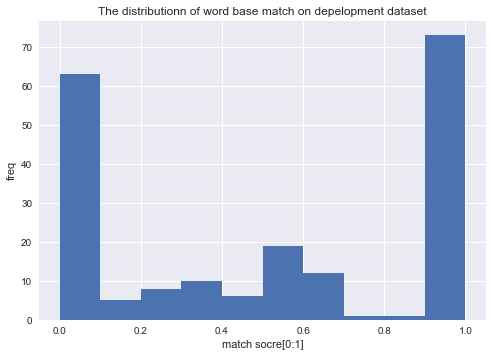

In [52]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.hist(list(score_dic.values()), bins=10)
ax.set_title('The distributionn of word base match on depelopment dataset')
ax.set_xlabel('match socre[0:1]')
ax.set_ylabel('freq')
plt.show()

In [54]:
df_question = pd.read_csv("df_dev_updated.csv")
df_question.head()

,Unnamed: 0,id,question,answer_0_text,answer_0_start,answer_1_text,answer_1_start,answer_2_text,answer_2_start,title,context,paragraph_idx,AnswerType,entities,NNPs,NNs,VBs,WP
0,0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Denver Broncos,177,Denver Broncos,177.0,Denver Broncos,177.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,HUMAN,"{'NFL': 'ORGANIZATION', '50': 'NUMBER'}","['NFL', 'AFC', 'Super', 'Bowl']",['team'],['represented'],[]
1,1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,249,Carolina Panthers,249.0,Carolina Panthers,249.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,HUMAN,"{'NFL': 'ORGANIZATION', 'NFC': 'ORGANIZATION',...","['NFL', 'Super', 'Bowl']","['team', 'NFC']",['represented'],[]
2,2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,"Santa Clara, California",403,Levi's Stadium,355.0,Levi's Stadium in the San Francisco Bay Area a...,355.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,LOCATION,{'50': 'NUMBER'},"['Super', 'Bowl']",['place'],['take'],[]
3,3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Denver Broncos,177,Denver Broncos,177.0,Denver Broncos,177.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,ENTITY,"{'NFL': 'ORGANIZATION', '50': 'NUMBER'}","['NFL', 'Super', 'Bowl']",['team'],[],[]
4,4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,gold,488,gold,488.0,gold,521.0,Super_Bowl_50,Super Bowl 50 was an American football game to...,0,ENTITY,{'50th': 'ORDINAL'},"['Super', 'Bowl']","['color', 'anniversary']","['used', 'emphasize']",[]


In [62]:
from collections import Counter

answer_type = {}
error_ans_type = []

for k, v in score_dic.items():
    temp_df= df_question[df_question["id"] == k].iloc[0]
    answer_type[k] = temp_df["AnswerType"]

    if v < 0.5:
        error_ans_type.append(answer_type[k])
ans_data = list(answer_type.values())
print(Counter(ans_data))
print(Counter(error_ans_type))

Counter({'ENTITY': 81, 'NUMERIC': 53, 'HUMAN': 33, 'DESCRIPTION': 21, 'LOCATION': 9, 'ABBEVIATION': 1})
Counter({'ENTITY': 39, 'NUMERIC': 26, 'HUMAN': 13, 'DESCRIPTION': 10, 'LOCATION': 4})


In [63]:
zero_match = []
for k, v in score_dic.items():
    if v < 0.01:
        zero_match.append(answer_type[k])
print(Counter(zero_match))

Counter({'ENTITY': 24, 'NUMERIC': 18, 'HUMAN': 11, 'DESCRIPTION': 8, 'LOCATION': 2})


## Error late between answers
- Entity : 0.481
- NUMERIC : 0.490
- HUMAN : 0.383
- DESCRIPTION : 0.476
- LOCATION : 0.444

### comments.
- DESCRIPTION
- HUMAN is the easiest question group.
- ENTITY question -> answer type classification problems...

## 0 match 
- Entity : 0.296
- NUMERIC : 0.339
- HUMAN : 0.333
- DESCRIPTION : 0.380
- LOCATION : 0.2222

### comments.
- HUMAN : dep_tag, const_tag -> with the same root, it's hard to decide which person should be picked up in close distance. 
- LOCATION : the focus points are correct, but miss some detail, like "Los Angerous, The United States" -> "The United States"